In [68]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [69]:
#Importing csv data
states_data = pd.read_csv('4.18states.csv')
counties = pd.read_csv('abridged_couties.csv')
confirmed = pd.read_csv('time_series_covid19_confirmed_US.csv')
deaths = pd.read_csv('time_series_covid19_deaths_US.csv')

In [70]:
#Cleaning Data to answer the following questions
#We will first create tables only where California is concerned
#We select certain features we thought would be useful and drop the rest (most of which were irrelevant or contained bad data)
ca_data = states_data[states_data["Province_State"] == "California"]
ca_counties = counties[counties["State"] == "California"][["countyFIPS", "PopulationEstimate2018", "FracMale2017", 
"MedianAge2010", "PopulationDensityperSqMile2010", "#FTEHospitalTotal2017", "TotalM.D.'s,TotNon-FedandFed2017", 
"MedicareEnrollment,AgedTot2017", "#ICU_beds", "SVIPercentile"]]

#Percentiles should not be negative
ca_counties = ca_counties[ca_counties["SVIPercentile"] > 0]

confirmed_ca = confirmed[confirmed["Province_State"] == "California"]
#We only care about total confirmed cases, which is also the column 4/18/20
confirmed_ca = confirmed_ca[["FIPS", "4/18/20"]]
confirmed_ca.columns = ["countyFIPS", "confirmed"]

#convert FIPS in both dataframes into int so they can be compared when we merge
ca_counties["countyFIPS"] = ca_counties["countyFIPS"].astype(int)
confirmed_ca["countyFIPS"] = confirmed_ca["countyFIPS"].astype(int)
#Merge confirmed columns into counties table using FIPS.
ca_counties = ca_counties.merge(confirmed_ca, on="countyFIPS")
#Dropping rows with NA values. If we filled it with zeros, it would skew the data.
ca_counties = ca_counties.dropna()
#Remove counties without sufficient confirmed data.
ca_counties = ca_counties[ca_counties["confirmed"] > 0]
#We attempt to predict confirmed proportion instead of a flat amount, as it takes into account the size of the counties
#Since we found out that usually these values would be very small, we multiply by 100
ca_counties["confirm_perc"] = (ca_counties["confirmed"]/ca_counties["PopulationEstimate2018"])*100

Text(0.5, 1.0, 'SVIPercentile vs confirmed cases')

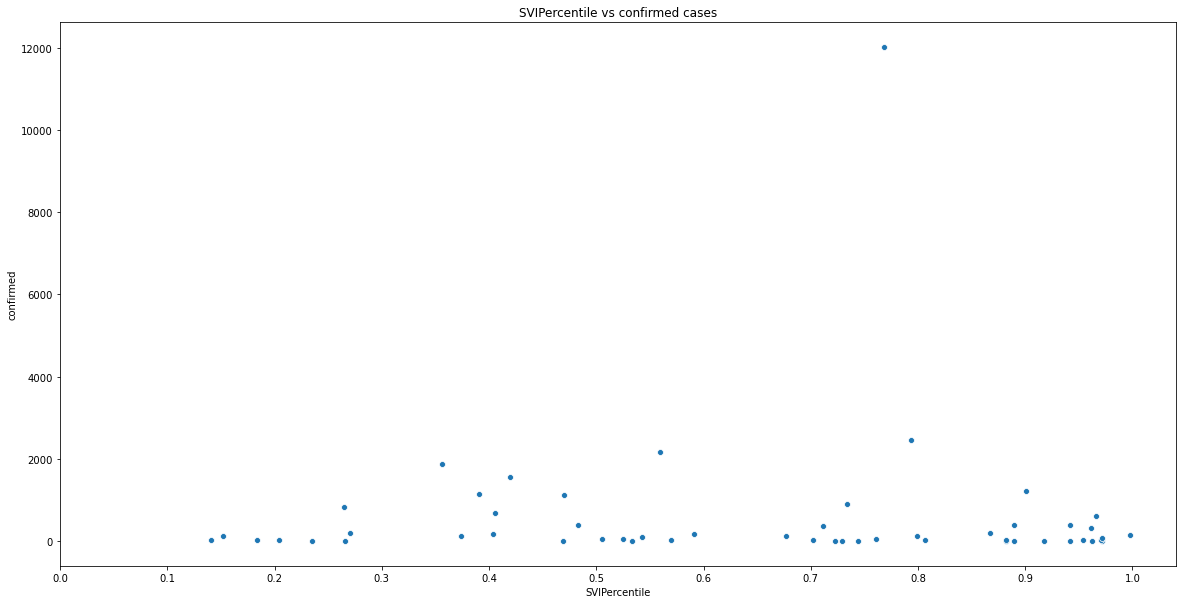

In [71]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(ca_counties["SVIPercentile"], ca_counties["confirmed"])
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.title("SVIPercentile vs confirmed cases")

In [72]:
#We conduct Train Test Split here, train data is 0.8 of our original and test data is 0.2
tr, te = train_test_split(ca_counties, test_size=0.2)

In [82]:
#Our training features don't require the IDs, the confirmed count, or the population estimate.
#Our used features are FractionMale2017, MedianAge2010, PopulationDensityperSqMile2010, #FTEHospitalTotal2017,
#TotalM.D.'s,TotNon-FedandFed2017, MedicareEnrollment,AgedTot2017, #ICU_beds, SVIPercentile
x_tr = tr.drop(['countyFIPS', 'confirmed', "confirm_perc", "PopulationEstimate2018"], axis = 1)
y_tr = tr["confirm_perc"]
x_te = te.drop(['countyFIPS', 'confirmed', "confirm_perc", "PopulationEstimate2018",], axis = 1)
y_te = te["confirm_perc"]

#Using Linear Regression, we predict the number of confirmed cases 
model = LinearRegression()
model.fit(x_tr, y_tr)
y_pred = model.predict(x_te)

#Function that computes RMSE
def computeRMSE(y, y_hat):
    return np.sqrt(1/(len(y)) * np.sum((y - y_hat) * (y - y_hat)))

#Function that computes cross_validation
def cross_validate_rmse(model, tr_x, tr_y, n):
    model = clone(model)
    n_fold = KFold(n_splits=n)
    rmse_values = []
    for tr_ind, va_ind in n_fold.split(tr_x):
        model.fit(tr_x.iloc[tr_ind,:], tr_y.iloc[tr_ind])
        rmse_values.append(computeRMSE(tr_y.iloc[va_ind], model.predict(tr_x.iloc[va_ind,:])))
    return np.mean(rmse_values)

print("RMSE: " + str(computeRMSE(y_te, y_pred)))
print("Cross Validation RMSE: " + str(cross_validate_rmse(model, x_tr, y_tr, 5)))
model.coef_

RMSE: 0.03911592958357266
Cross Validation RMSE: 0.058715574751977063


array([ 1.35563972e+00, -2.63016089e-03,  4.12522528e-06, -1.01008606e-08,
       -7.77128537e-06,  8.27087232e-08,  1.15557362e-04, -6.88835858e-02])

Initially, we wished to train on the California data because we wanted to predict if different confirmed cases in Californian counties. However, because many Californian counties didn't actually report their number of cases, we lost a lot of data. Despite having a relatively decent RMSE, we would like to have a larger dataset. For the next part, we will attempt to use the entirety of the US as training data.

In [79]:
#This follows the same process as the first few cells. We only take the features we want and rename the date column to something more meaningful.
clean_counties = counties[["countyFIPS", "PopulationEstimate2018", "FracMale2017", 
"MedianAge2010", "PopulationDensityperSqMile2010", "#FTEHospitalTotal2017", "TotalM.D.'s,TotNon-FedandFed2017", 
"MedicareEnrollment,AgedTot2017", "#ICU_beds", "SVIPercentile"]]
#For some features, having a value of 0 means it should get cleaned
clean_counties = clean_counties[clean_counties["SVIPercentile"] > 0]
clean_counties = clean_counties[clean_counties["PopulationEstimate2018"] > 0]
#For other features, we should just drop only NA values, as 0 is a possible value
clean_counties = clean_counties.dropna()

clean_confirm = confirmed[["FIPS", "4/18/20"]]
clean_confirm.columns = ["countyFIPS", "confirmed"]
#Cleaning clean_confirm as well because there are some rows with NaN FIPS values
clean_confirm = clean_confirm.dropna()

#convert FIPS in both dataframes into int so they can be compared when we merge
clean_counties["countyFIPS"] = clean_counties["countyFIPS"].astype(int)
clean_confirm["countyFIPS"] = clean_confirm["countyFIPS"].astype(int)
#Merge confirmed columns into counties table using FIPS.
clean_counties = clean_counties.merge(clean_confirm, on="countyFIPS")
#Remove counties without sufficient confirmed data.
clean_counties = clean_counties[clean_counties["confirmed"] > 0]
#We are going to change the confirm column into a percentage
clean_counties["confirm_perc"] = (clean_counties["confirmed"]/clean_counties["PopulationEstimate2018"])*100

c:\users\rober\anaconda3\envs\py36\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Log Population Density vs Logged Percentage of confirmed cases')

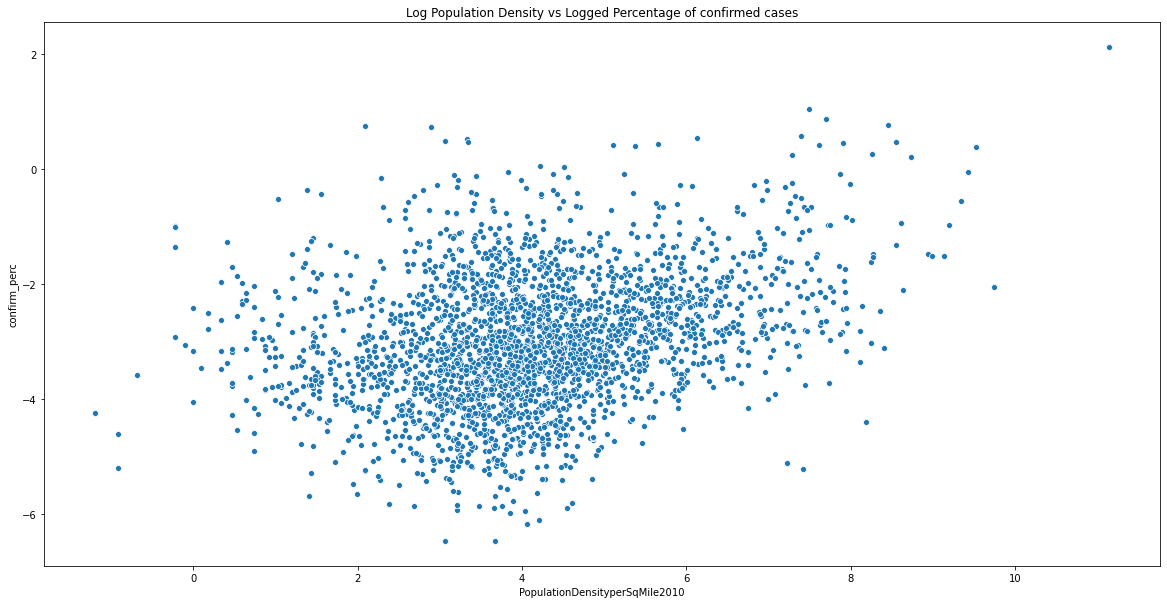

In [80]:
fig, ax = plt.subplots(figsize = (20, 10))
sns.scatterplot(np.log(clean_counties["PopulationDensityperSqMile2010"]), np.log(clean_counties["confirm_perc"]))
plt.title("Log Population Density vs Logged Percentage of confirmed cases")

In [81]:
#We conduct Train Test Split here, train data is 0.8 of our original and test data is 0.2
tr2, te2 = train_test_split(clean_counties, test_size=0.2)
x_tr2 = tr2.drop(['countyFIPS', 'confirmed', "confirm_perc", "PopulationEstimate2018"], axis = 1)
y_tr2 = tr2["confirm_perc"]
x_te2 = te2.drop(['countyFIPS', 'confirmed', "confirm_perc", "PopulationEstimate2018"], axis = 1)
y_te2 = te2["confirm_perc"]
#Using Linear Regression, we predict the number of confirmed cases 
model2 = LinearRegression()
model2.fit(x_tr2, y_tr2)

print(cross_validate_rmse(model2, x_tr2, y_tr2, 5))
y_hat = model2.predict(x_te2)
print(computeRMSE(y_te2, y_hat))

model2.coef_

0.17219101655219052
0.23439471702363462


array([-2.44968843e-01, -1.28115542e-03,  7.65905624e-05, -3.79204671e-06,
        2.78570050e-05,  5.10606923e-07, -3.94073463e-04,  5.48354079e-02])

We will now use PCA to see if we can find anything interesting with our features

In [16]:
copy1 = clean_counties.copy()
copy = copy1.drop(['countyFIPS', 'deaths', 'confirmed', "confirm_perc"], axis = 1)
copy_centered = copy - np.mean(copy, axis = 0)
u, s, vt = np.linalg.svd(copy_centered, full_matrices = False)
#sigma_1 is the vector that containing the sigma value corresponding to the first pc
sigma_1 = np.array([s[0], 0, 0, 0])
#to retrieve all the values associated with pc1, we dot product u with sigma1
pc1 = u@sigma_1;
copy1["pc1"] = pc1
copy1

,countyFIPS,PopulationEstimate2018,PopulationDensityperSqMile2010,"MedicareEnrollment,AgedTot2017",SVIPercentile,deaths,confirmed,confirm_perc,pc1
1,1003.0,218022.0,114.7,41590.0,0.2162,5,136,0.000624,-1.083608e+05
2,1005.0,24881.0,31.0,4706.0,0.9959,2,14,0.000563,8.790835e+04
3,1007.0,22400.0,36.8,3389.0,0.6003,60,1118,0.049911,9.053716e+04
4,1009.0,57840.0,88.9,9542.0,0.4242,3,53,0.000916,5.460161e+04
5,1011.0,10138.0,17.5,1434.0,0.8898,2,25,0.002466,1.029484e+05
6,1013.0,19680.0,27.0,3571.0,0.8653,2,109,0.005539,9.321168e+04
7,1015.0,114277.0,195.7,20142.0,0.8252,0,18,0.000158,-2.726893e+03
8,1017.0,33615.0,57.4,6342.0,0.7382,0,26,0.000773,7.903693e+04
9,1019.0,26032.0,46.9,5195.0,0.4516,0,20,0.000768,8.670432e+04
10,1021.0,44153.0,63.0,6786.0,0.7602,0,9,0.000204,6.852847e+04


By observing the patterns of the columns and the values of the PCA, we notice that pc1 is referencing medicare enrollment. For large values, the pca value takes on a negative number, while for small enrollments, the pca takes on a smaller number.

This tells us that between different counties, medicare enrollment is the thing that differentiates them from each other the most. To tell if this could be a good feature, we need to look at the context medicare enrollment can have on confirmed cases. Having medicare implies that people will go to the hospital if sick. If someone has medicare, then they are also more likely to become confirmed. Also, the amount of people having medicare can closely relate to the population, with more people in a population means more people enrolled in medicare.

Text(0.5, 1.0, 'pc1 vs Medicare Enrollment')

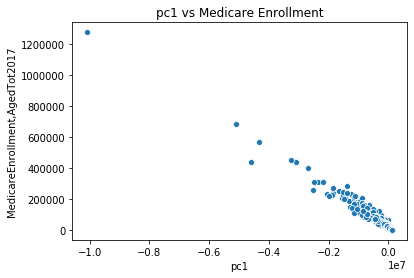

In [29]:
sns.scatterplot(copy1["pc1"], copy1["MedicareEnrollment,AgedTot2017"])
plt.title("pc1 vs Medicare Enrollment")

Text(0.5, 1.0, 'Medicare Enrollment vs Population Estimate')

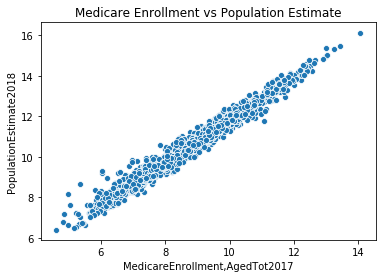

In [30]:
sns.scatterplot(np.log(copy1["MedicareEnrollment,AgedTot2017"]), np.log(copy1["PopulationEstimate2018"]))
plt.title("Medicare Enrollment vs Population Estimate")

As we can see, medicare does grow with population linearly, meaning choosing medicare enrollment as a feature would also be implicitly making population a sort of pseudo-feature as well. Both of these are important to determining how sickness spreads, so using Medicare Enrollment does not seem to be a bad idea. 